# Soreq - Hartuv Station
In this notebook we will be looking at Soreq - Hartuv station which is near the Soreq river and in Bet Shemesh area. This notebook uses data from 2018 to 2021 with the addition of rainfall data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/My Drive/Colab Notebooks"

/content/drive/My Drive/Colab Notebooks


In [ ]:
!pip install import-ipynb
import import_ipynb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.9 MB/s eta 0:00:00


In [ ]:
from functions import *

importing Jupyter notebook from functions.ipynb


In [ ]:
# fix random seed for reproducibility
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)

Loading the data after preprocessing:

In [ ]:
path_flow = '/content/drive/MyDrive/FinalProjectDataScience/flow_in_hydro_stations.xlsx'
df = pd.read_excel(path_flow)

In [ ]:
df_flow = df.copy(deep=True)

In [ ]:
df_flow.head()

,gauge_id,time,flow,water_level
0,2105,1966-10-01 00:00:00,0.000,0.00
1,2105,1966-12-19 18:35:00,0.027,2.88
2,2105,1966-12-19 18:35:00,0.027,0.00
3,2105,1966-12-19 18:45:00,0.037,2.90
4,2105,1966-12-19 19:00:00,0.037,2.90


In [ ]:
path_catalog = '/content/drive/MyDrive/FinalProjectDataScience/hydro_stations_catalog.xlsx'
df_catalog = pd.read_excel(path_catalog)

In [ ]:
df_catalog.head()

,זיהוי תחנה,שם עברית,שם אנגלית,שם קודם,תאריך הקמה,שטח היקוות (קמר),X .נ.צ,Y .נ.צ,קשר עם תחנה קודמת,תחום התנקזות ראשי,סטטוס תחנה
0,1102,בצת-כביש 4,BEZET- ROAD 4,כרכרה,27/01/2015,102.0,211086.0,775565.0,NaN,בצת,לא פעילה
1,1105,בצת - ע''י אילון,BEZET - NEAR AYYALON,NaN,01/10/1949,71.0,221150.0,775650.0,NaN,בצת,לא פעילה
2,1106,בצת - ע''י חורבת כרכרה,BEZET - NEAR AYYALON,NaN,01/10/1944,71.0,220950.0,775350.0,NaN,בצת,לא פעילה
3,2105,כזיב - גשר הזיו,KEZIV - HAZIV BRIDGE,כביר,01/10/1966,130.0,210315.0,772922.0,NaN,כזיב,פעילה
4,2106,כזיב - גשר הרכבת,KEZIV - RAILWAY BRIDGE,כביר,01/10/1944,131.0,210100.0,772800.0,2105.0,כזיב,לא פעילה


# Pipeline

Our approach is to build a different LSTM model for each station.

Since running a model for each station is computationaly heavy, we will choose specific stations that are of interest, and run the model on them only.

The pipeline is:

1. Run a basic LSTM model on a specific gauge - without additional data.
2. Run an LSTM model with the addition of the rainfall data.
3. Compare between the 2 models.
4. Run hyperparameter optimization on the LSTM model with the rainfall data.
5. Run LSTM model after optimization.
6. Run a GRU model with the rainfall data.
7. Run hyperparameter optimization on the GRU model with the rainfall data.
8. Compare results between LSTM and GRU.

## Hyperparameters

In [ ]:
# Time Resolution
time_resolution = '10T'

# Number of sequences in the data per hour (depends on time resolution)
sequences_per_hour = 6

# Lead time (by hours)
l = 3

# Number of epochs
epochs = 5

# Batch size
batch_size = 128

# Number of years to train over
n_train_years = 3

# size of validation set
validation_split = 0.333

## Preprocess

In [ ]:
gauge_id = 18115
gauge_name = df_catalog[df_catalog['זיהוי תחנה'] == gauge_id]['שם אנגלית'].iloc[0]

In [ ]:
gauge_df = get_data_of_gauge(gauge_id)
gauge_df.drop(columns=['gauge_id'], inplace=True)

<ipython-input-26-2081e5c32cd2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df.drop(columns=['gauge_id'], inplace=True)


In [ ]:
# Set 'timestamp' as the DataFrame index
gauge_df['time'] = pd.to_datetime(gauge_df['time'])

<ipython-input-27-cfd5998e3239>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gauge_df['time'] = pd.to_datetime(gauge_df['time'])


In [ ]:
gauge_df = gauge_df[(gauge_df['time'].dt.year >= START_YEAR) & (gauge_df['time'].dt.year <= END_YEAR)]

In [ ]:
gauge_df = resample_data(gauge_df, time_resolution)

In [ ]:
gauge_df

,flow,water_level
time,,
2018-01-01 00:00:00,1.072000,2.54000
2018-01-01 00:10:00,1.087200,2.54400
2018-01-01 00:20:00,1.102400,2.54800
2018-01-01 00:30:00,1.117600,2.55200
2018-01-01 00:40:00,1.132800,2.55600
...,...,...
2021-12-09 21:40:00,0.558625,2.00125
2021-12-09 21:50:00,0.554000,2.00000
2021-12-09 22:00:00,0.554000,2.00000


In [ ]:
# prepare loss function
std = gauge_df['flow'].std()
nse_star = get_nse_loss(std)

In [ ]:
# prepare nse metric
mean = gauge_df['flow'].mean()
nse_tensor = get_nse_tensor(mean)
nse_numpy = get_nse_numpy(mean)

## Choice of Lead Time

In [ ]:
nse_means = {1:0, 2:0, 3:0}
persist_nse_means = {1:0, 2:0, 3:0}
n_iter = 3

for i in range(n_iter):
  for lead_time in range(1, 4):
    # number of lag hours
    n_hours = lead_time * sequences_per_hour
    reframed, scaler = prepare_data(gauge_df, n_hours)

    # number of total features
    n_features = len(gauge_df.columns)

    # drop columns of reframed that are not for prediction
    n_cols_reframed = len(reframed.columns)
    reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

    # split into train and test sets
    n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
    train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

    # prepare creating model
    metrics = [persistent_nse_tensor, nse_tensor]
    create_model = build_model(train_X, nse_star, metrics, LSTM)

    # run model
    model = create_model()
    history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

    # make a prediction
    yhat = model.predict(test_X)
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))

    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]

    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]

    # calculate NSE
    nse_numpy = get_nse_numpy(mean)
    nse_metric = nse_numpy(inv_y, inv_yhat)
    nse_means[lead_time] += nse_metric/n_iter

    # calculate persistNSE
    persist_nse_metric = persistent_nse_numpy(inv_y, inv_yhat)
    persist_nse_means[lead_time] += persist_nse_metric/n_iter

Epoch 1/5
822/822 - 5s - loss: 0.0105 - persistent_nse_tensor: 0.8631 - nse_tensor: 0.9998 - val_loss: 0.0012 - val_persistent_nse_tensor: 0.9805 - val_nse_tensor: 1.0000 - 5s/epoch - 6ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0039 - persistent_nse_tensor: 0.9393 - nse_tensor: 0.9999 - val_loss: 0.0012 - val_persistent_nse_tensor: 0.9786 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 3s - loss: 0.0029 - persistent_nse_tensor: 0.9573 - nse_tensor: 1.0000 - val_loss: 0.0014 - val_persistent_nse_tensor: 0.9762 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0036 - persistent_nse_tensor: 0.9389 - nse_tensor: 1.0000 - val_loss: 0.0015 - val_persistent_nse_tensor: 0.9740 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0031 - persistent_nse_tensor: 0.9597 - nse_tensor: 1.0000 - val_loss: 0.0016 - val_persistent_nse_tensor: 0.9724 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
1548/1548 [========================

In [ ]:
nse_means

{1: 0.8319045131997689, 2: 0.8800938004686072, 3: 0.9347494860251271}

In [ ]:
persist_nse_means

{1: 0.1081623647206699, 2: 0.363724824725404, 3: 0.6536993477086334}

We can see that the best choice for lead time by both mean scores is 3 hours.

## LSTM model without rainfall data

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(gauge_df, n_hours)

# number of total features
n_features = len(gauge_df.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

    var1(t-18)  var2(t-18)  var1(t-17)  var2(t-17)  var1(t-16)  var2(t-16)  \
18    0.011842    0.239437    0.012051    0.240845    0.012260    0.242254   
19    0.012051    0.240845    0.012260    0.242254    0.012469    0.243662   
20    0.012260    0.242254    0.012469    0.243662    0.012678    0.245070   
21    0.012469    0.243662    0.012678    0.245070    0.012886    0.246479   
22    0.012678    0.245070    0.012886    0.246479    0.013147    0.248239   

    var1(t-15)  var2(t-15)  var1(t-14)  var2(t-14)  ...  var2(t-5)  var1(t-4)  \
18    0.012469    0.243662    0.012678    0.245070  ...   0.253521   0.013930   
19    0.012678    0.245070    0.012886    0.246479  ...   0.253521   0.013781   
20    0.012886    0.246479    0.013147    0.248239  ...   0.252515   0.013632   
21    0.013147    0.248239    0.013408    0.250000  ...   0.251509   0.013483   
22    0.013408    0.250000    0.013669    0.251761  ...   0.250503   0.013334   

    var2(t-4)  var1(t-3)  var2(t-3)  var1(t-

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
822/822 - 5s - loss: 0.0096 - persistent_nse_tensor: 0.8578 - nse_tensor: 0.9999 - val_loss: 9.5357e-04 - val_persistent_nse_tensor: 0.9849 - val_nse_tensor: 1.0000 - 5s/epoch - 7ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0034 - persistent_nse_tensor: 0.9448 - nse_tensor: 1.0000 - val_loss: 9.9278e-04 - val_persistent_nse_tensor: 0.9843 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 4s - loss: 0.0028 - persistent_nse_tensor: 0.9615 - nse_tensor: 1.0000 - val_loss: 0.0017 - val_persistent_nse_tensor: 0.9730 - val_nse_tensor: 1.0000 - 4s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0053 - persistent_nse_tensor: 0.9241 - nse_tensor: 0.9999 - val_loss: 9.2722e-04 - val_persistent_nse_tensor: 0.9860 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0021 - persistent_nse_tensor: 0.9648 - nse_tensor: 1.0000 - val_loss: 0.0011 - val_persistent_nse_tensor: 0.9839 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step


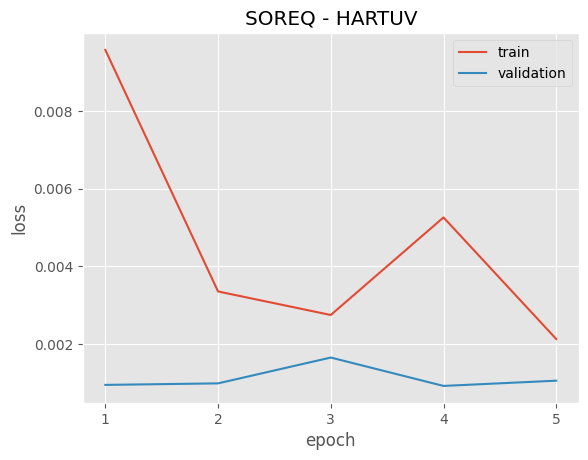

In [ ]:
plot_history(epochs, history, gauge_name)

1548/1548 [==============================] - 3s 2ms/step
Test NSE: 0.950
Test PersistentNSE: 0.734


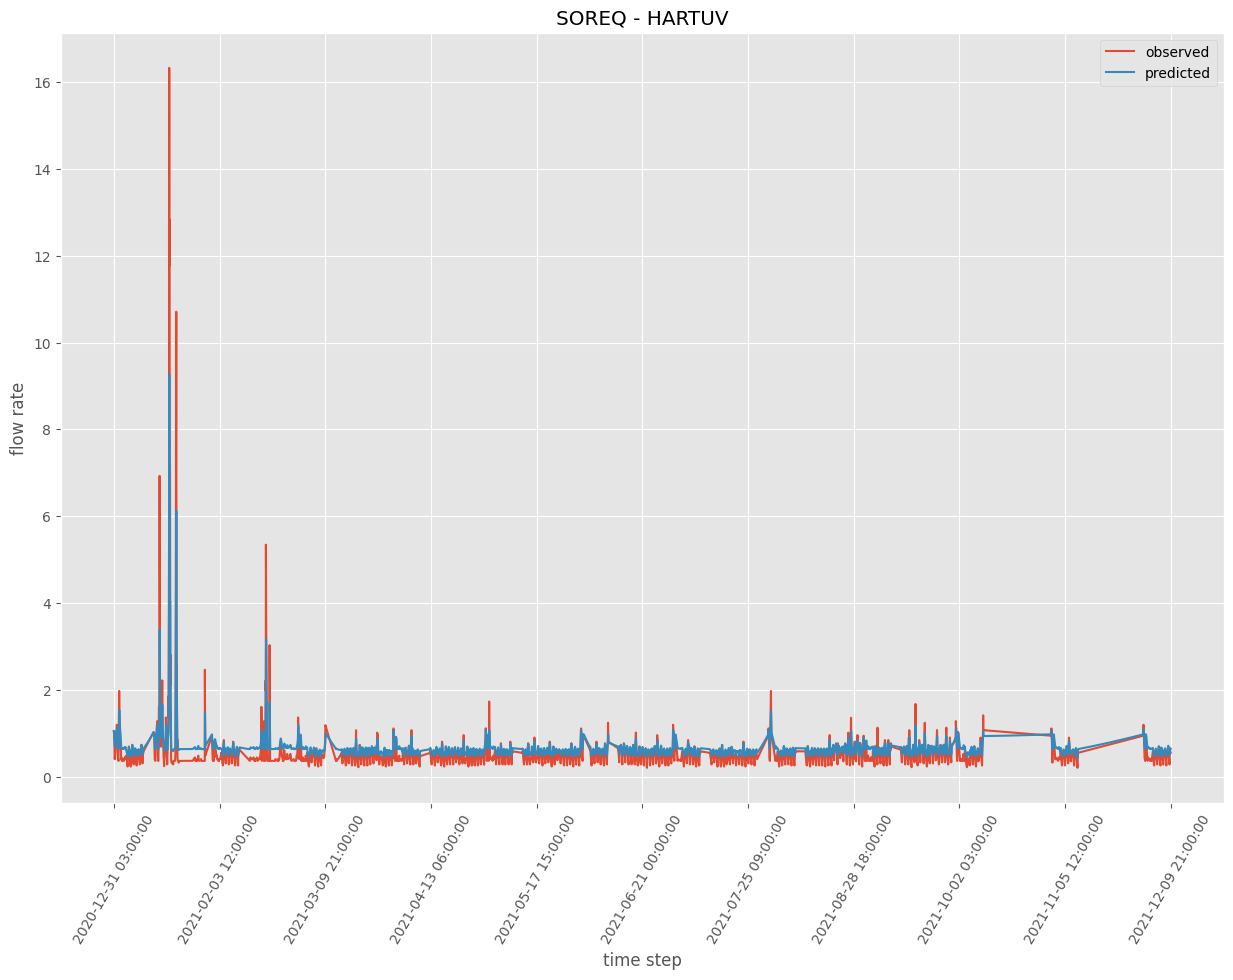

In [ ]:
time_test = list(gauge_df.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_without_precipitation = history.history['val_persistent_nse_tensor']

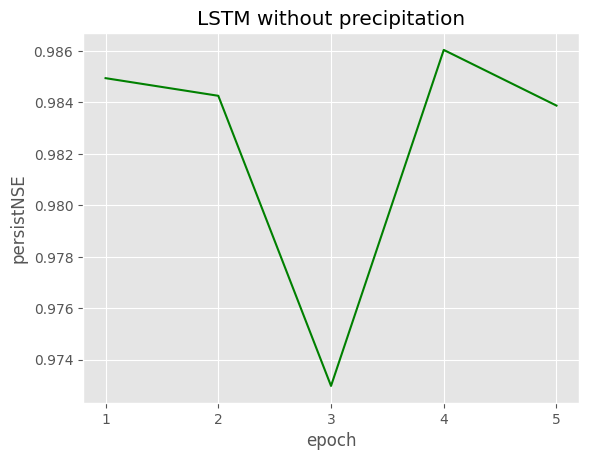

In [ ]:
plt.plot(persist_nse_without_precipitation, c='green')
plt.title('LSTM without precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## LSTM model with rainfall data

### Rainfall data from 3 closest rain stations

In [ ]:
ims_stations = [40551, 40652, 40656]

In [ ]:
dfs_stations = []
for i, ims_id in enumerate(ims_stations):

  dfs_rain = []
  for year in range(START_YEAR, END_YEAR+1):
    rain_path = f'/content/drive/MyDrive/FinalProjectDataScience/IMS/gauge_{gauge_id}/{year}/{ims_id}_.txt'
    df_rain = pd.read_csv(rain_path, delimiter=',')
    df_rain.rename(columns={'Date_Time[]': 'time', 'Rain[mm]': f'rain[mm]_ims_{i+1}'}, inplace=True)

    # impute -999.0 (null) values to zero
    df_rain[f'rain[mm]_ims_{i+1}'] = df_rain[f'rain[mm]_ims_{i+1}'].apply(lambda x: 0 if x == -999.0 else x)
    dfs_rain.append(df_rain)

  df_merged_rain = pd.concat(dfs_rain, ignore_index=True)
  df_merged_rain['time'] = pd.to_datetime(df_merged_rain['time'])
  dfs_stations.append(df_merged_rain)

In [ ]:
# time resolution of rain data is 10 minutes by default
if time_resolution != '10T':
  for i in range(len(dfs_stations)):
    dfs_stations[i] = resample_data(dfs_stations[i], time_resolution)
    dfs_stations[i].reset_index(inplace=True)

In [ ]:
gauge_df.reset_index(inplace=True)

In [ ]:
df_flow_rain_merged = gauge_df.copy(deep=True)
for df in dfs_stations:
  df_flow_rain_merged = pd.merge(df_flow_rain_merged, df, on='time')

In [ ]:
gauge_df.set_index('time', inplace=True)

In [ ]:
df_flow_rain_merged.set_index('time', inplace=True)

In [ ]:
df_flow_rain_merged

,flow,water_level,rain[mm]_ims_1,rain[mm]_ims_2,rain[mm]_ims_3
time,,,,,
2018-01-01 00:00:00,1.072000,2.54000,0.0,0.0,0.0
2018-01-01 00:10:00,1.087200,2.54400,0.0,0.0,0.0
2018-01-01 00:20:00,1.102400,2.54800,0.0,0.0,0.0
2018-01-01 00:30:00,1.117600,2.55200,0.0,0.0,0.0
2018-01-01 00:40:00,1.132800,2.55600,0.0,0.0,0.0
...,...,...,...,...,...
2021-12-09 21:40:00,0.558625,2.00125,0.0,0.0,0.0
2021-12-09 21:50:00,0.554000,2.00000,0.0,0.0,0.0
2021-12-09 22:00:00,0.554000,2.00000,0.0,0.0,0.0


### Training and Validation

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

    var1(t-18)  var2(t-18)  var3(t-18)  var4(t-18)  var5(t-18)  var1(t-17)  \
18    0.011842    0.239437         0.0         0.0         0.0    0.012051   
19    0.012051    0.240845         0.0         0.0         0.0    0.012260   
20    0.012260    0.242254         0.0         0.0         0.0    0.012469   
21    0.012469    0.243662         0.0         0.0         0.0    0.012678   
22    0.012678    0.245070         0.0         0.0         0.0    0.012886   

    var2(t-17)  var3(t-17)  var4(t-17)  var5(t-17)  ...  var2(t-2)  var3(t-2)  \
18    0.240845         0.0         0.0         0.0  ...   0.251509        0.0   
19    0.242254         0.0         0.0         0.0  ...   0.250503        0.0   
20    0.243662         0.0         0.0         0.0  ...   0.249497        0.0   
21    0.245070         0.0         0.0         0.0  ...   0.248491        0.0   
22    0.246479         0.0         0.0         0.0  ...   0.247485        0.0   

    var4(t-2)  var5(t-2)  var1(t-1)  var2(t-

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
822/822 - 5s - loss: 0.0104 - persistent_nse_tensor: 0.8484 - nse_tensor: 0.9998 - val_loss: 9.4986e-04 - val_persistent_nse_tensor: 0.9851 - val_nse_tensor: 1.0000 - 5s/epoch - 7ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0034 - persistent_nse_tensor: 0.9448 - nse_tensor: 1.0000 - val_loss: 0.0010 - val_persistent_nse_tensor: 0.9846 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 3s - loss: 0.0022 - persistent_nse_tensor: 0.9675 - nse_tensor: 1.0000 - val_loss: 9.9582e-04 - val_persistent_nse_tensor: 0.9851 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0023 - persistent_nse_tensor: 0.9676 - nse_tensor: 1.0000 - val_loss: 0.0013 - val_persistent_nse_tensor: 0.9809 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0034 - persistent_nse_tensor: 0.9495 - nse_tensor: 1.0000 - val_loss: 9.9321e-04 - val_persistent_nse_tensor: 0.9851 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step


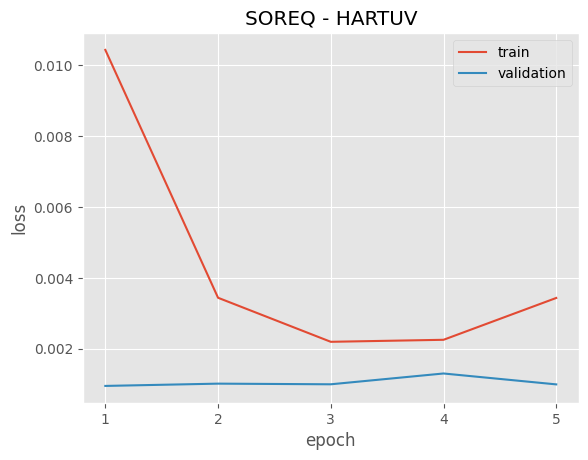

In [ ]:
plot_history(epochs, history, gauge_name)

1548/1548 [==============================] - 3s 2ms/step
Test NSE: 0.962
Test PersistentNSE: 0.797


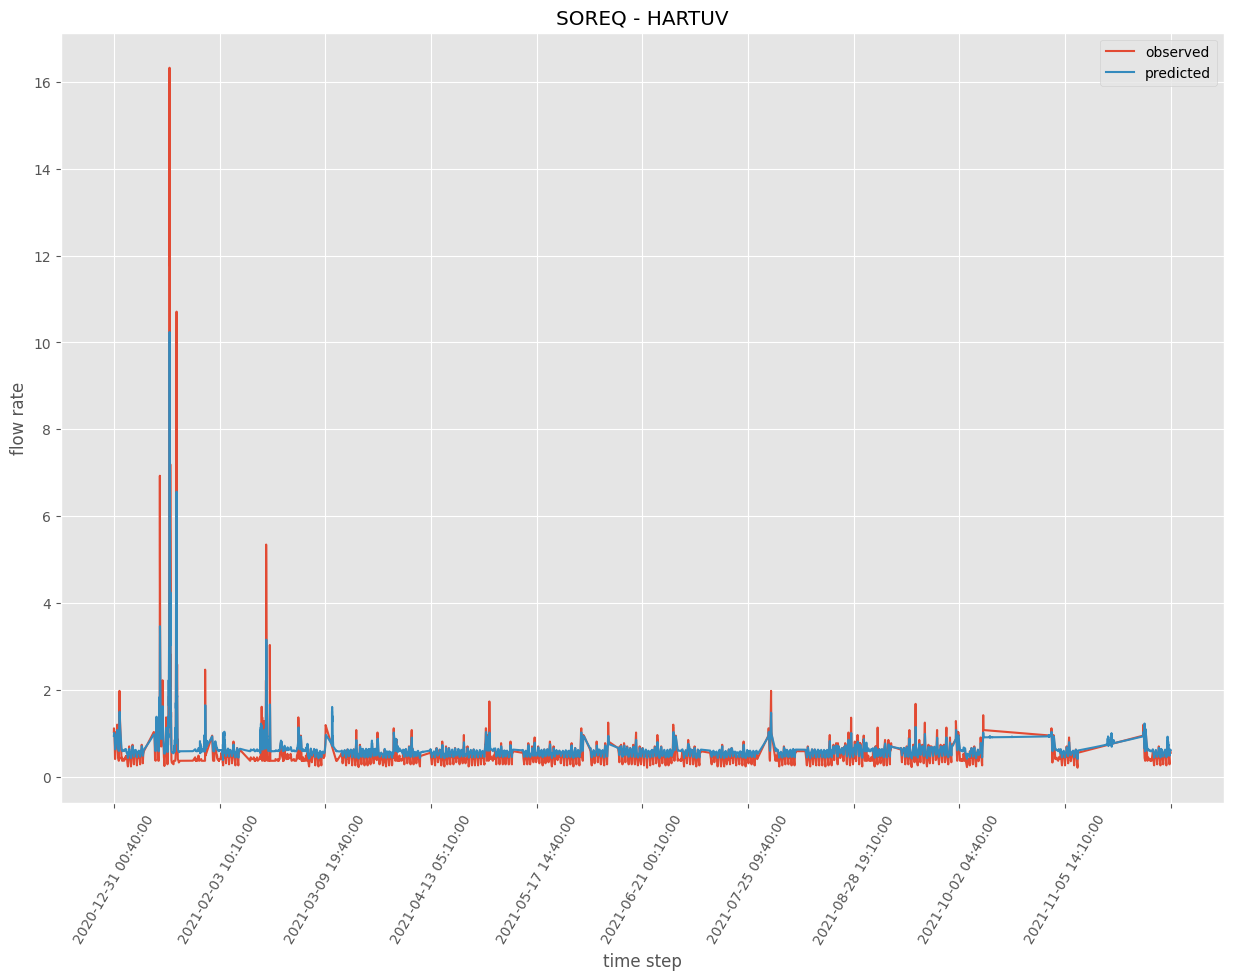

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_lstm = history.history['val_persistent_nse_tensor']

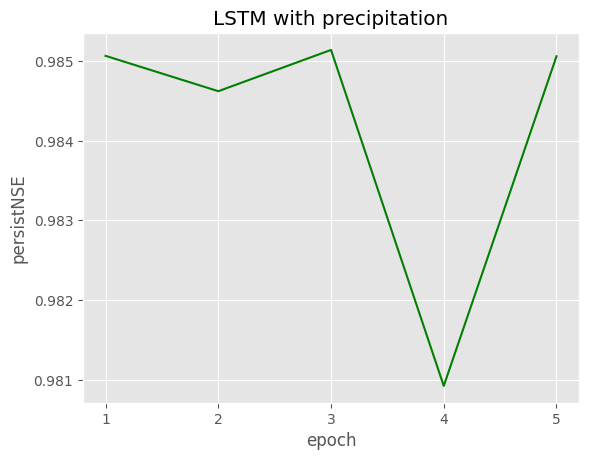

In [ ]:
plt.plot(persist_nse_with_precipitation_lstm, c='green')
plt.title('LSTM with precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

### Hyperparameter Optimization

In [ ]:
model = KerasRegressor(build_fn=create_model, n_neurons=128)

In [ ]:
from keras.src.layers.serialization import activation
param_grid = dict(epochs=[5, 10, 15], batch_size=[32, 64, 128], n_neurons=[64, 128])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(persistent_nse_numpy), n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_X, train_y)
print("Done grid search")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
1232/1232 [==============================] - 6s 3ms/step - loss: 0.0020 - persistent_nse_tensor: 0.9725 - nse_tensor: 1.0000
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0017 - persistent_nse_tensor: 0.9776 - nse_tensor: 1.0000
Epoch 3/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0015 - persistent_nse_tensor: 0.9798 - nse_tensor: 1.0000
Epoch 4/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0015 - persistent_nse_tensor: 0.9800 - nse_tensor: 1.0000
Epoch 5/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0012 - persistent_nse_tensor: 0.9830 - nse_tensor: 1.0000
Done grid search


In [ ]:
print("Best: test score %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for m, s, param in zip(means, stds, params):
    print("mean test score %f (std test score %f) with: %r" % (m, s, param))

Best: test score 0.906898 using {'batch_size': 128, 'epochs': 5, 'n_neurons': 64}
mean test score 0.715676 (std test score 0.301757) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 64}
mean test score 0.717095 (std test score 0.318639) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 128}
mean test score 0.495343 (std test score 0.651748) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 64}
mean test score 0.264919 (std test score 0.934015) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 128}
mean test score 0.492578 (std test score 0.614787) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 64}
mean test score 0.564190 (std test score 0.453448) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 128}
mean test score 0.755143 (std test score 0.252315) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 64}
mean test score 0.758777 (std test score 0.246355) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 128}
mean test score 0.462966 (std test score 0.689341) with: {'bat

In [ ]:
def highlight_max_row(data):
    """Highlight the entire row if mean_test_score is the maximum."""
    max_score = data['mean_test_score'].max()
    highlight = ['background-color: yellow' if val == max_score else '' for val in data['mean_test_score']]
    return pd.DataFrame([highlight for _ in data.columns], index=data.columns).T

In [ ]:
df_grid = pd.DataFrame({
    'param_batch_size': grid_result.cv_results_['param_batch_size'].data,
    'param_epochs': grid_result.cv_results_['param_epochs'].data,
    'param_n_neurons': grid_result.cv_results_['param_n_neurons'].data,
    'mean_test_score': grid_result.cv_results_['mean_test_score']
})

df_grid.style.apply(highlight_max_row, axis=None)

,param_batch_size,param_epochs,param_n_neurons,mean_test_score
0,32,5,64,0.715676
1,32,5,128,0.717095
2,32,10,64,0.495343
3,32,10,128,0.264919
4,32,15,64,0.492578
5,32,15,128,0.564190
6,64,5,64,0.755143
7,64,5,128,0.758777
8,64,10,64,0.462966
9,64,10,128,0.524948


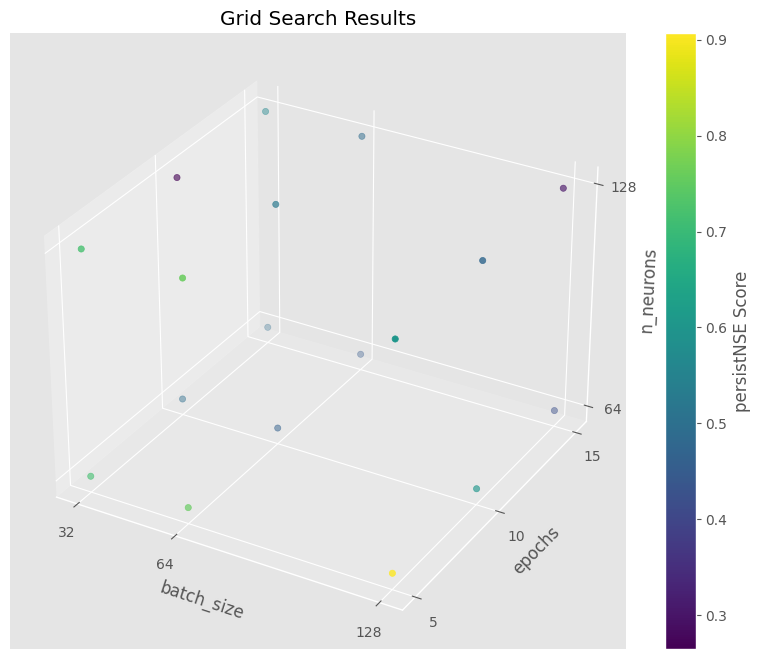

In [ ]:
import plotly.graph_objs as go
# Create a meshgrid for the three parameters
param_batch_size = grid_result.cv_results_['param_batch_size'].data
param_epochs = grid_result.cv_results_['param_epochs'].data
param_n_neurons = grid_result.cv_results_['param_n_neurons'].data
performance_scores = grid_result.cv_results_['mean_test_score']
# param1, param2, param3 = np.meshgrid(param_batch_size, param_epochs, param_n_neurons)
param1, param2, param3 = param_batch_size, param_epochs, param_n_neurons

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing performance
scatter = ax.scatter(param1, param2, param3, c=performance_scores, cmap='viridis')
fig.colorbar(scatter, label='persistNSE Score')

# Set labels and title
ax.set_xlabel('batch_size')
ax.set_xticks([32, 64, 128])
ax.set_ylabel('epochs')
ax.set_yticks([5, 10, 15])
ax.set_zlabel('n_neurons')
ax.set_zticks([64, 128])
ax.set_title('Grid Search Results')

# Show the plot
plt.show()

### Running Model After Hyperparameter Optimization

In [ ]:
# Best hyperparameters
epochs_best_lstm = 5
n_neurons_best_lstm = 64
batch_size_best_lstm = 128

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, LSTM)

model = create_model(n_neurons_best_lstm)
history = model.fit(train_X, train_y, epochs=epochs_best_lstm, batch_size=batch_size_best_lstm, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
822/822 - 5s - loss: 0.0093 - persistent_nse_tensor: 0.8628 - nse_tensor: 0.9999 - val_loss: 0.0011 - val_persistent_nse_tensor: 0.9827 - val_nse_tensor: 1.0000 - 5s/epoch - 7ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0030 - persistent_nse_tensor: 0.9565 - nse_tensor: 1.0000 - val_loss: 7.7223e-04 - val_persistent_nse_tensor: 0.9876 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 3s - loss: 0.0034 - persistent_nse_tensor: 0.9570 - nse_tensor: 1.0000 - val_loss: 0.0021 - val_persistent_nse_tensor: 0.9675 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0075 - persistent_nse_tensor: 0.9173 - nse_tensor: 0.9999 - val_loss: 0.0011 - val_persistent_nse_tensor: 0.9842 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0034 - persistent_nse_tensor: 0.9509 - nse_tensor: 0.9999 - val_loss: 6.6515e-04 - val_persistent_nse_tensor: 0.9900 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step


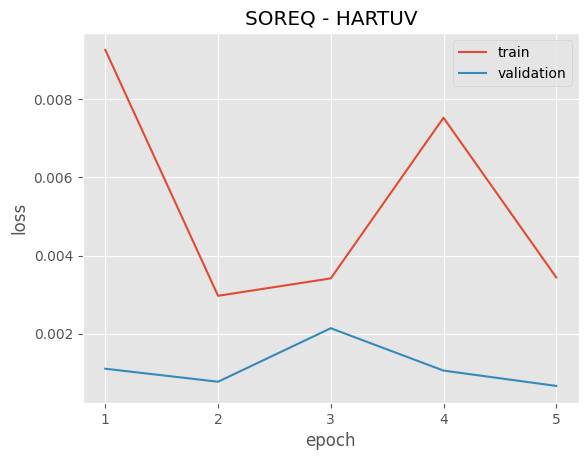

In [ ]:
plot_history(epochs_best_lstm, history, gauge_name)

1548/1548 [==============================] - 3s 2ms/step
Test NSE: 0.957
Test PersistentNSE: 0.770


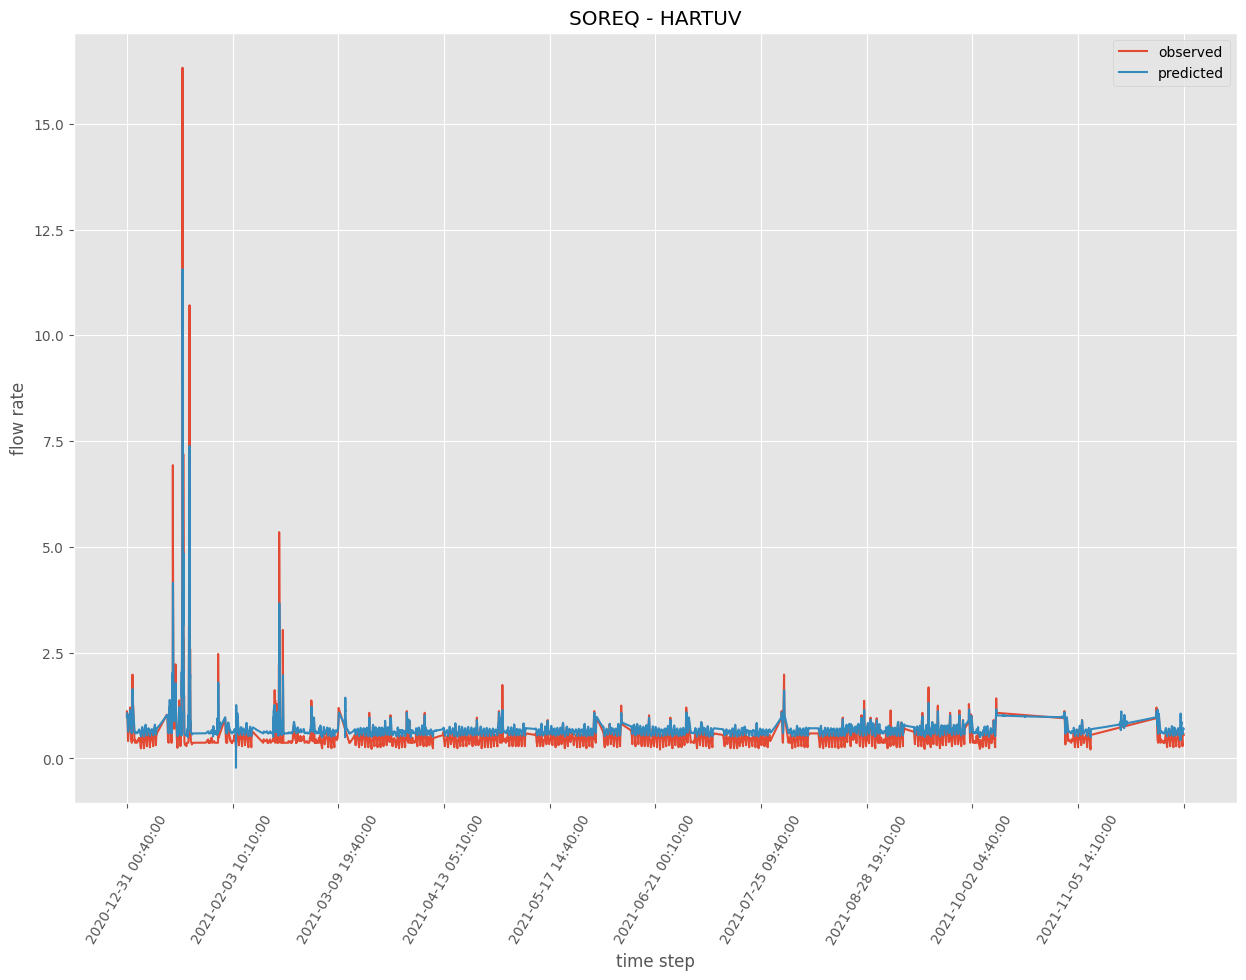

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_opt_lstm = history.history['val_persistent_nse_tensor']

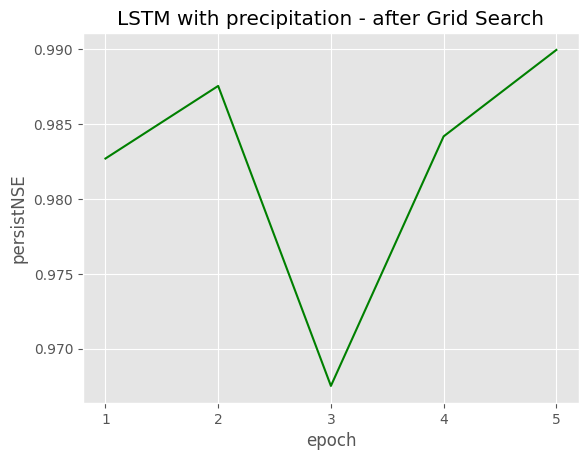

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_lstm, c='green')
plt.title('LSTM with precipitation - after Grid Search')
plt.xticks(np.arange(epochs_best_lstm), np.arange(1, epochs_best_lstm+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## GRU model with rainfall data

### Training and Validation

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

print(reframed.head())

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

    var1(t-18)  var2(t-18)  var3(t-18)  var4(t-18)  var5(t-18)  var1(t-17)  \
18    0.011842    0.239437         0.0         0.0         0.0    0.012051   
19    0.012051    0.240845         0.0         0.0         0.0    0.012260   
20    0.012260    0.242254         0.0         0.0         0.0    0.012469   
21    0.012469    0.243662         0.0         0.0         0.0    0.012678   
22    0.012678    0.245070         0.0         0.0         0.0    0.012886   

    var2(t-17)  var3(t-17)  var4(t-17)  var5(t-17)  ...  var2(t-2)  var3(t-2)  \
18    0.240845         0.0         0.0         0.0  ...   0.251509        0.0   
19    0.242254         0.0         0.0         0.0  ...   0.250503        0.0   
20    0.243662         0.0         0.0         0.0  ...   0.249497        0.0   
21    0.245070         0.0         0.0         0.0  ...   0.248491        0.0   
22    0.246479         0.0         0.0         0.0  ...   0.247485        0.0   

    var4(t-2)  var5(t-2)  var1(t-1)  var2(t-

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, GRU)

# run model
model = create_model()
history = model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
822/822 - 5s - loss: 0.0096 - persistent_nse_tensor: 0.8222 - nse_tensor: 0.9999 - val_loss: 7.4791e-04 - val_persistent_nse_tensor: 0.9894 - val_nse_tensor: 1.0000 - 5s/epoch - 7ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0044 - persistent_nse_tensor: 0.9253 - nse_tensor: 0.9999 - val_loss: 8.7984e-04 - val_persistent_nse_tensor: 0.9873 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 3s - loss: 0.0040 - persistent_nse_tensor: 0.9319 - nse_tensor: 0.9999 - val_loss: 6.9815e-04 - val_persistent_nse_tensor: 0.9903 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0032 - persistent_nse_tensor: 0.9462 - nse_tensor: 1.0000 - val_loss: 7.8306e-04 - val_persistent_nse_tensor: 0.9890 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0031 - persistent_nse_tensor: 0.9490 - nse_tensor: 1.0000 - val_loss: 8.3745e-04 - val_persistent_nse_tensor: 0.9882 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step


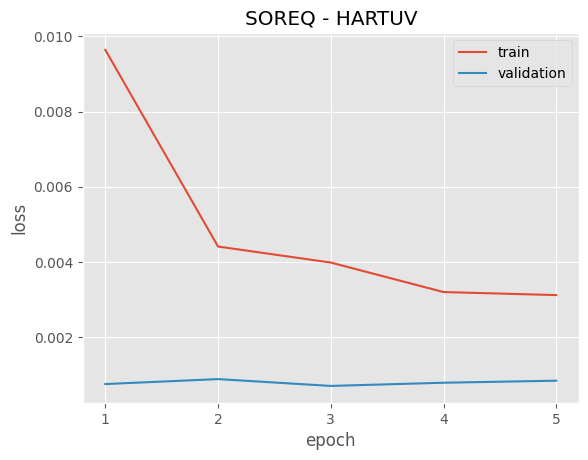

In [ ]:
plot_history(epochs, history, gauge_name)

1548/1548 [==============================] - 3s 2ms/step
Test NSE: 0.961
Test PersistentNSE: 0.794


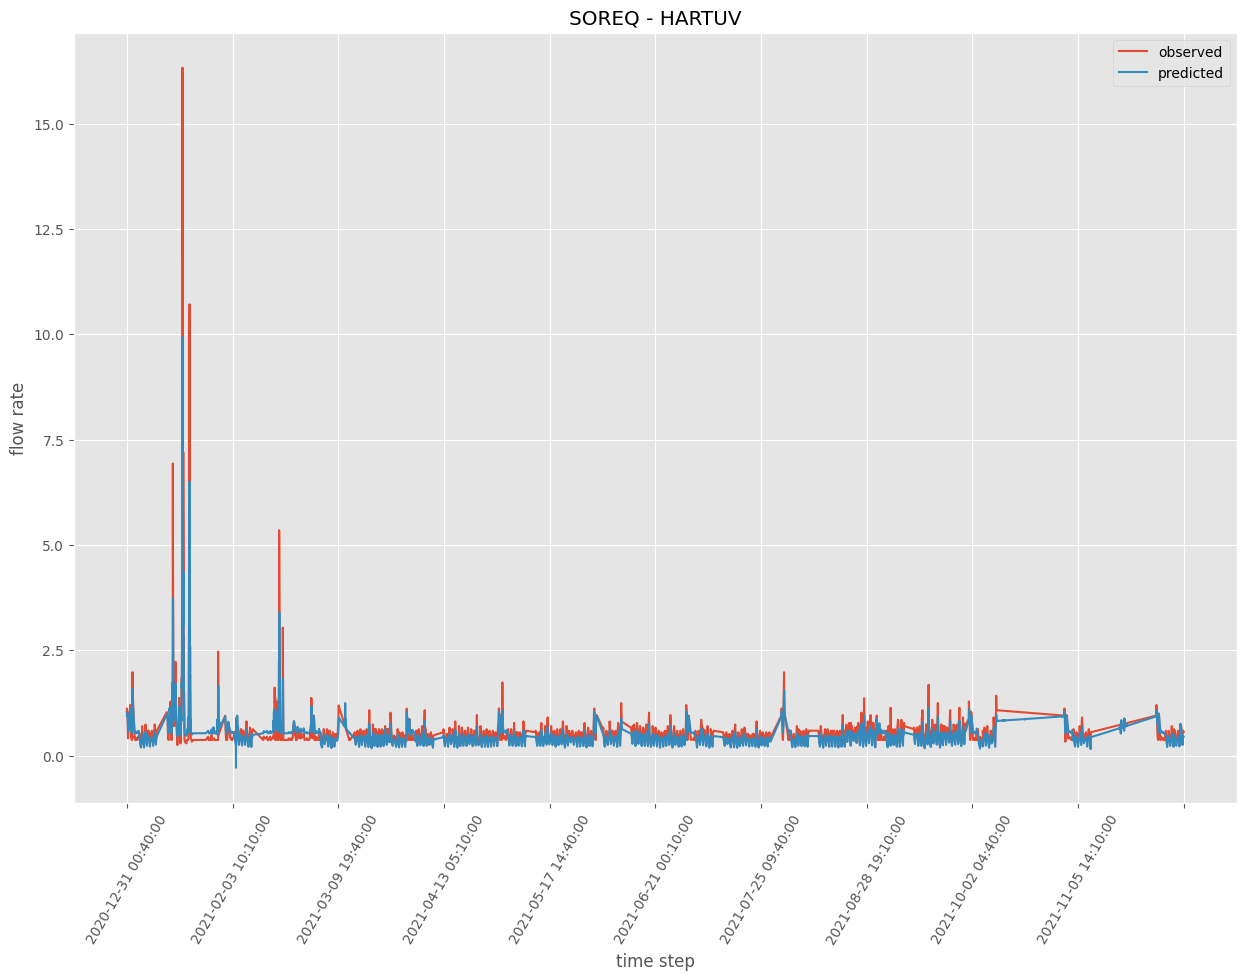

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_gru = history.history['val_persistent_nse_tensor']

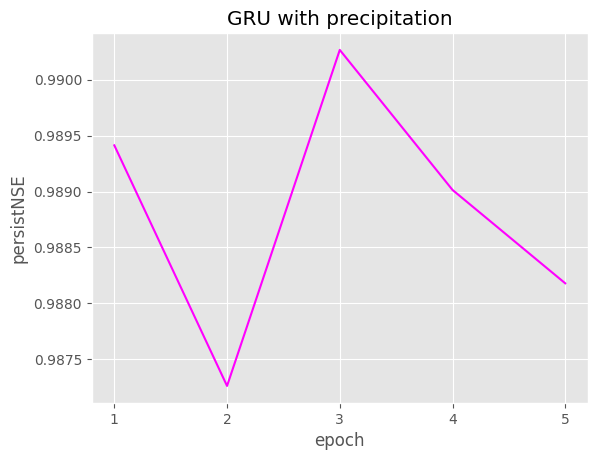

In [ ]:
plt.plot(persist_nse_with_precipitation_gru, c='magenta')
plt.title('GRU with precipitation')
plt.xticks(np.arange(epochs), np.arange(1, epochs+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

### Hyperparameter Optimization

In [ ]:
model = KerasRegressor(build_fn=create_model, n_neurons=128)

In [ ]:
from keras.src.layers.serialization import activation
param_grid = dict(epochs=[5, 10, 15], batch_size=[32, 64, 128], n_neurons=[64, 128])
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=make_scorer(persistent_nse_numpy), n_jobs=-1, cv=3, verbose=2)
grid_result = grid.fit(train_X, train_y)
print("Done grid search")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
1232/1232 [==============================] - 6s 3ms/step - loss: 0.0020 - persistent_nse_tensor: 0.9723 - nse_tensor: 1.0000
Epoch 2/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0016 - persistent_nse_tensor: 0.9783 - nse_tensor: 1.0000
Epoch 3/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0013 - persistent_nse_tensor: 0.9808 - nse_tensor: 1.0000
Epoch 4/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0012 - persistent_nse_tensor: 0.9830 - nse_tensor: 1.0000
Epoch 5/5
1232/1232 [==============================] - 4s 3ms/step - loss: 0.0012 - persistent_nse_tensor: 0.9837 - nse_tensor: 1.0000
Done grid search


In [ ]:
print("Best: test score %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for m, s, param in zip(means, stds, params):
    print("mean test score %f (std test score %f) with: %r" % (m, s, param))

Best: test score 0.796951 using {'batch_size': 128, 'epochs': 5, 'n_neurons': 64}
mean test score 0.561835 (std test score 0.470490) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 64}
mean test score 0.596720 (std test score 0.458847) with: {'batch_size': 32, 'epochs': 5, 'n_neurons': 128}
mean test score 0.501697 (std test score 0.595067) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 64}
mean test score 0.498600 (std test score 0.591770) with: {'batch_size': 32, 'epochs': 10, 'n_neurons': 128}
mean test score 0.528459 (std test score 0.547780) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 64}
mean test score 0.562307 (std test score 0.450862) with: {'batch_size': 32, 'epochs': 15, 'n_neurons': 128}
mean test score 0.456606 (std test score 0.615600) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 64}
mean test score 0.719300 (std test score 0.244592) with: {'batch_size': 64, 'epochs': 5, 'n_neurons': 128}
mean test score 0.578921 (std test score 0.509194) with: {'bat

In [ ]:
df_grid = pd.DataFrame({
    'param_batch_size': grid_result.cv_results_['param_batch_size'].data,
    'param_epochs': grid_result.cv_results_['param_epochs'].data,
    'param_n_neurons': grid_result.cv_results_['param_n_neurons'].data,
    'mean_test_score': grid_result.cv_results_['mean_test_score']
})

df_grid.style.apply(highlight_max_row, axis=None)

,param_batch_size,param_epochs,param_n_neurons,mean_test_score
0,32,5,64,0.561835
1,32,5,128,0.596720
2,32,10,64,0.501697
3,32,10,128,0.498600
4,32,15,64,0.528459
5,32,15,128,0.562307
6,64,5,64,0.456606
7,64,5,128,0.719300
8,64,10,64,0.578921
9,64,10,128,0.391318


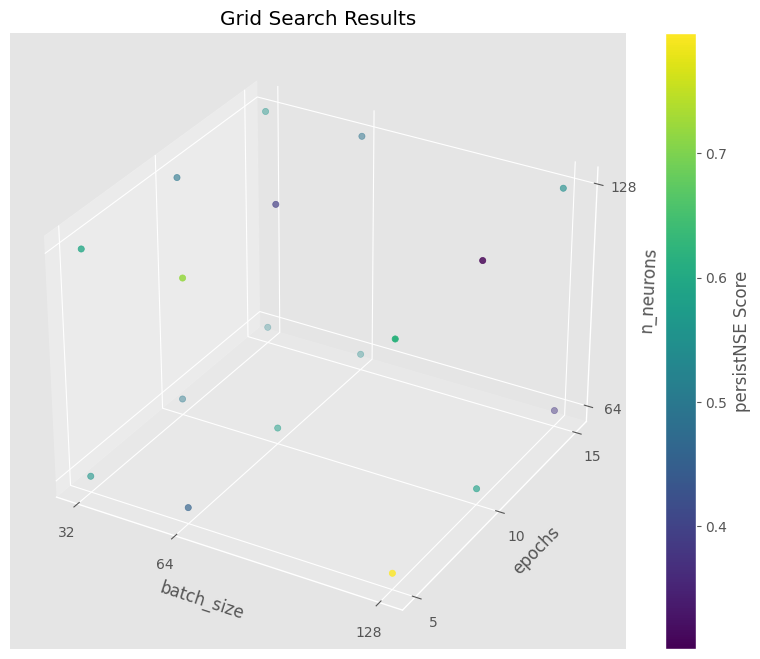

In [ ]:
import plotly.graph_objs as go
# Create a meshgrid for the three parameters
param_batch_size = grid_result.cv_results_['param_batch_size'].data
param_epochs = grid_result.cv_results_['param_epochs'].data
param_n_neurons = grid_result.cv_results_['param_n_neurons'].data
performance_scores = grid_result.cv_results_['mean_test_score']
# param1, param2, param3 = np.meshgrid(param_batch_size, param_epochs, param_n_neurons)
param1, param2, param3 = param_batch_size, param_epochs, param_n_neurons

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color representing performance
scatter = ax.scatter(param1, param2, param3, c=performance_scores, cmap='viridis')
fig.colorbar(scatter, label='persistNSE Score')

# Set labels and title
ax.set_xlabel('batch_size')
ax.set_xticks([32, 64, 128])
ax.set_ylabel('epochs')
ax.set_yticks([5, 10, 15])
ax.set_zlabel('n_neurons')
ax.set_zticks([64, 128])
ax.set_title('Grid Search Results')

# Show the plot
plt.show()

### Running Model After Hyperparameter Optimization

In [ ]:
# Best hyperparameters
epochs_best_gru = 5
n_neurons_best_gru = 64
batch_size_best_gru = 128

In [ ]:
# number of lag hours
n_hours = l * sequences_per_hour
reframed, scaler = prepare_data(df_flow_rain_merged, n_hours)

# number of total features
n_features = len(df_flow_rain_merged.columns)

# drop columns of reframed that are not for prediction
n_cols_reframed = len(reframed.columns)
reframed.drop(reframed.columns[n_cols_reframed-n_features+1:], axis=1, inplace=True)

# split into train and test sets
n_train_sequences = n_train_years * DAYS_PER_YEAR * HOURS_PER_DAY * sequences_per_hour
train_X, train_y, test_X, test_y = split_train_and_test(reframed, n_train_sequences, n_hours, n_features)

In [ ]:
# prepare creating model
metrics = [persistent_nse_tensor, nse_tensor]
create_model = build_model(train_X, nse_star, metrics, GRU)

model = create_model(n_neurons_best_gru)
history = model.fit(train_X, train_y, epochs=epochs_best_gru, batch_size=batch_size_best_gru, validation_split=validation_split, verbose=2, shuffle=False)

Epoch 1/5
822/822 - 6s - loss: 0.0124 - persistent_nse_tensor: 0.8432 - nse_tensor: 0.9998 - val_loss: 0.0010 - val_persistent_nse_tensor: 0.9841 - val_nse_tensor: 1.0000 - 6s/epoch - 7ms/step
Epoch 2/5
822/822 - 3s - loss: 0.0045 - persistent_nse_tensor: 0.9329 - nse_tensor: 0.9999 - val_loss: 5.6366e-04 - val_persistent_nse_tensor: 0.9914 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 3/5
822/822 - 3s - loss: 0.0033 - persistent_nse_tensor: 0.9486 - nse_tensor: 1.0000 - val_loss: 6.4703e-04 - val_persistent_nse_tensor: 0.9901 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 4/5
822/822 - 3s - loss: 0.0030 - persistent_nse_tensor: 0.9484 - nse_tensor: 1.0000 - val_loss: 7.3796e-04 - val_persistent_nse_tensor: 0.9893 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step
Epoch 5/5
822/822 - 3s - loss: 0.0031 - persistent_nse_tensor: 0.9511 - nse_tensor: 1.0000 - val_loss: 8.7630e-04 - val_persistent_nse_tensor: 0.9872 - val_nse_tensor: 1.0000 - 3s/epoch - 4ms/step


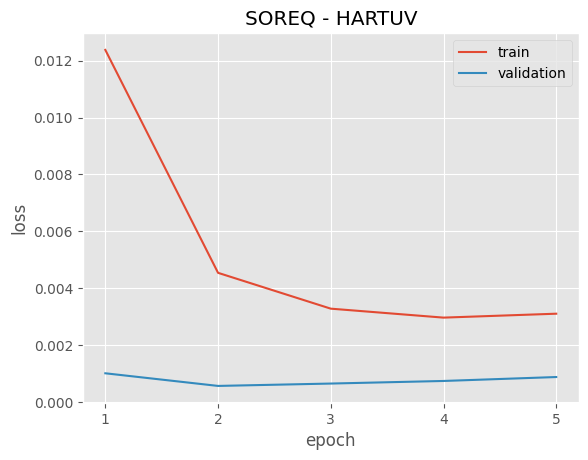

In [ ]:
plot_history(epochs_best_gru, history, gauge_name)

1548/1548 [==============================] - 3s 2ms/step
Test NSE: 0.955
Test PersistentNSE: 0.761


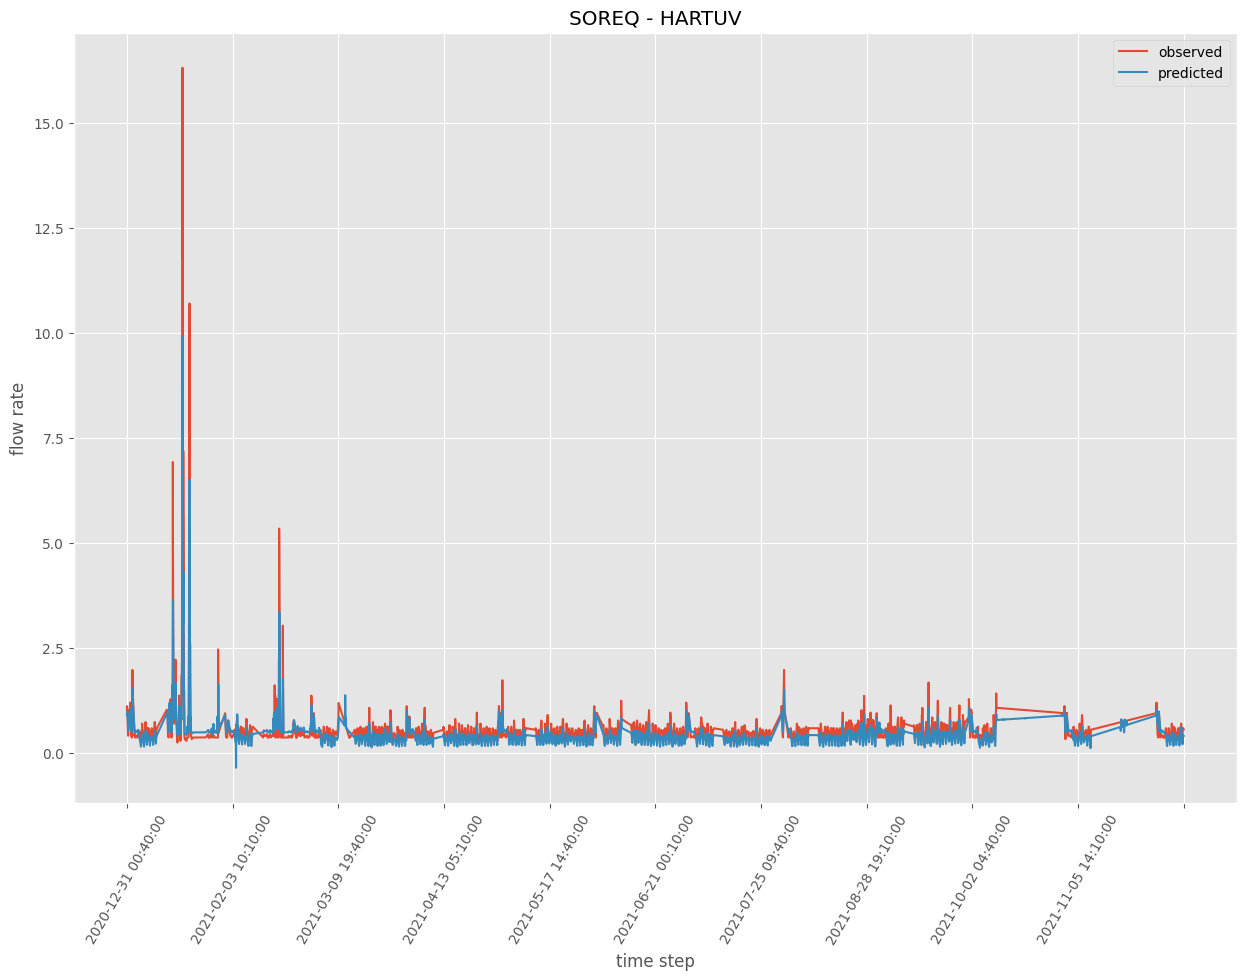

In [ ]:
time_test = list(df_flow_rain_merged.reset_index(inplace=False).iloc[n_train_sequences+n_hours:, 0].astype('str'))
plot_predicted_vs_observed(model, scaler, test_X, test_y, n_hours, n_features, mean, time_test, gauge_name)

In [ ]:
persist_nse_with_precipitation_opt_gru = history.history['val_persistent_nse_tensor']

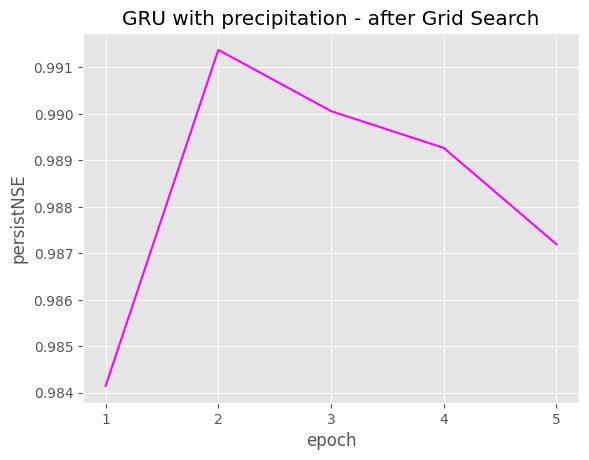

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_gru, c='magenta')
plt.title('GRU with precipitation - after Grid Search')
plt.xticks(np.arange(epochs_best_gru), np.arange(1, epochs_best_gru+1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.show()

## LSTM VS GRU

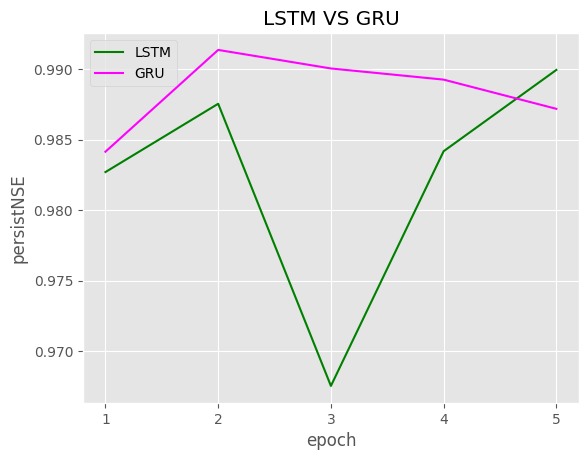

In [ ]:
plt.plot(persist_nse_with_precipitation_opt_lstm, label='LSTM', c='green')
plt.plot(persist_nse_with_precipitation_opt_gru, label='GRU', c='magenta')
plt.title('LSTM VS GRU')
epochs_max = max(epochs_best_lstm, epochs_best_gru)
plt.xticks(np.arange(epochs_max), np.arange(1, epochs_max + 1))
plt.xlabel('epoch')
plt.ylabel('persistNSE')
plt.legend()
plt.show()